## III. Write an implementation of the Spectral Clustering algorithm, using either basic unnormalized clustering or normalized clustering (refer to the reading by Luxborg for details). Assume you are given a matrix of data X ∈ R N×d , and you would like to identify some user-selected number of clusters, K. Your outputs should be:
- a weighted adjacency matrix, W, using the Gaussian similarity function based on the Eu- clidean distance (with parameter value σ of your choice but clearly stated) and a k-nearest neighborhood structure (where k is also your choice and clearly stated);

- a matrix U containing the ﬁrst K eigenvectors of the Laplacian L (or generalized eigenvectors for the normalized case).; 

- a cluster index vector C ∈ {1, 2, . . . , K} N , where C(i) = j indicates that the ith row of U belongs to cluster j.

### basic unnormalized clustering

In [106]:
import csv
import math
import numpy as np
import scipy as sp
from scipy.linalg import eigh
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [107]:
with open('/Users/macbookpro/Desktop/IE529_Comp2/Dataset_1/clustering.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    x = list(reader)
    data_1 = np.array(x).astype("float")
    
    
with open('/Users/macbookpro/Desktop/IE529_Comp2/Dataset_2/ShapedData.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    x = list(reader)
    data_2 = np.array(x).astype("float")

#### Define adj matrix

In [109]:
# Gaussian similarity function
# For example, one can choose σ in the order of the mean distance of a point to its k-th nearest neighbor, 
# where k is chosen similarly as above (e.g., k ∼ log(n) + 1 ). like σ=5
def adj_generate(X, gamma):
    n = X.shape[0]
    a = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = math.exp(-math.pow(norm((X[i]-X[j]),2), 2) * gamma)
    return a

In [108]:
# k-nearest neighborhood structure
# k -> log(n) -> 3 or 4
def adj_generate_KNN(X, k):
    n = X.shape[0]
    a = np.zeros([n,n])
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    idx = neigh.kneighbors(X,  n_neighbors=k, return_distance=False)
    for i in range(n):
        for j in range(n):
            if j in idx[i]:
                a[i,j] = 1
    return a

In [110]:
def diag_generate(a):
    n = a.shape[0]
    d = np.sum(a, axis = 1)
    return np.diagflat(d)

#### Kmeans below

In [111]:
# Randomly initialize centroids
def centroids_init(matrix, K):
    index = np.random.randint(low=0, high=len(matrix[:,0]), size=K)
    centroids = matrix[index]
    return centroids

In [135]:
def find_closest_centroids(matrix, centroids):
    # Set m
    m = centroids.shape[0]
    
    # initialize distance matrix
    distance = np.zeros((matrix.shape[0], m))

    for i in range(matrix.shape[0]):
        for j in range(m):
#             distance[i][j] = math.sqrt((centroids[j][0] - matrix[i][0])**2 + (centroids[j][1] - matrix[i][1])**2)
            distance[i,j] = math.pow(norm((matrix[i,:]-centroids[j,:]),2), 0.5)
    idx = np.argmin(distance, axis=1)
#     new_centroids = centroids[idx]
    return idx

In [191]:
def compute_centroids(matrix, idx, K):
    temp = []
    for j in range(matrix.shape[1]):
        a = matrix[np.where(idx == 0)][:,j].sum()
        b = len(matrix[np.where(idx == 0)])
        temp.append(a/b)
    centroids = np.array([temp])
    for i in range(1, K):
        index = matrix[np.where(idx == i)]
        temp = []
        for i in range(matrix.shape[1]):
            temp.append(index[:,i].sum()/len(index))
        centroids = np.concatenate((centroids, np.array([temp])))
    return centroids

In [201]:
def compute_distortion(matrix, idx, centroids, K):
    distance = []
    for i in range(K):
        group = matrix[np.where(idx == i)]
        for j in range(group.shape[0]):
            distance.append(math.pow(norm((centroids[i,:]-group[j,:]),2), 2))
    distortion = 0
    for i in distance:
        distortion += i
    return distortion

#### Play with Dataset 2 with Gaussian similarity function
Kmeans on spectral clustering

In [348]:
X = data_2
K = 6
gamma = 1

In [349]:
# Adjacency matrix
A = adj_generate(X, gamma)
# degree-diagonal matrix
D = diag_generate(A)


# Unnormalized clustering, Lapalacian matrix
L = D - A

# # Normalized Lapalacian matrix
# def normalize_adj(A, D): 
#     d_inv_sqrt = np.power(D, -0.5)
#     d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
#     L = sp.eye(D.shape[0]) - d_inv_sqrt.dot(A.dot(d_inv_sqrt))
#     return L
# L = normalize_adj(A, D)

eigValue, U = np.asarray(eigh(L, eigvals=(1,K)))

In [327]:
# parameters initialization
max_iter = 300
val = [0.001, 10**(-5)] # val = 10**-5

centroids = centroids_init(U, K)

for _ in range(max_iter):
    idx = find_closest_centroids(U, centroids)
    new_centroids = compute_centroids(U, idx, K)
    d = compute_distortion(U, idx, centroids, K)
    d_new = compute_distortion(U, idx, new_centroids, K)
    if abs(d_new - d) < val[1]:
        break
    else:
        centroids = new_centroids
        new_centroids = compute_centroids(U, idx, K)

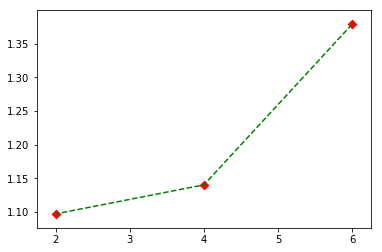

In [358]:
plt.plot(K_list, inertia, 'g--')
K_list = K_list[::-1]
inertia = inertia[::-1]
plt.scatter(K_list, inertia, c='r', marker = 'D')
plt.savefig('D_K.svg',format='svg')
plt.show()

In [234]:
U

array([[ 0.00196131,  0.00126425, -0.02279465, -0.01080707],
       [-0.01753502,  0.01297361,  0.00511127,  0.021116  ],
       [-0.01696202,  0.01281366,  0.003664  ,  0.02615788],
       ..., 
       [-0.01552786,  0.00891799,  0.00610137, -0.02019692],
       [-0.01651182,  0.01054058,  0.00645384, -0.01175206],
       [ 0.02509135,  0.01065055,  0.01192572,  0.00288991]])

In [235]:
A

array([[  1.00000000e+00,   2.17643668e-07,   4.55907711e-05, ...,
          2.00765232e-06,   1.21849549e-05,   1.20500035e-07],
       [  2.17643668e-07,   1.00000000e+00,   2.95233116e-01, ...,
          1.51993327e-10,   1.21553359e-06,   1.27463324e-20],
       [  4.55907711e-05,   2.95233116e-01,   1.00000000e+00, ...,
          5.54987749e-11,   2.33137852e-07,   9.67884363e-15],
       ..., 
       [  2.00765232e-06,   1.51993327e-10,   5.54987749e-11, ...,
          1.00000000e+00,   2.93388113e-01,   2.00118945e-25],
       [  1.21849549e-05,   1.21553359e-06,   2.33137852e-07, ...,
          2.93388113e-01,   1.00000000e+00,   3.24640735e-24],
       [  1.20500035e-07,   1.27463324e-20,   9.67884363e-15, ...,
          2.00118945e-25,   3.24640735e-24,   1.00000000e+00]])

#### Play with Dataset 1 with Gaussian similarity function
Kmeans on spectral clustering

In [360]:
X = data_1
K = 2
gamma = 1

In [361]:
# Adjacency matrix
A = adj_generate(X, gamma)
# degree-diagonal matrix
D = diag_generate(A)


# Unnormalized clustering, Lapalacian matrix
L = D - A

# # Normalized Lapalacian matrix
# def normalize_adj(A, D): 
#     d_inv_sqrt = np.power(D, -0.5)
#     d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
#     L = sp.eye(D.shape[0]) - d_inv_sqrt.dot(A.dot(d_inv_sqrt))
#     return L
# L = normalize_adj(A, D)

eigValue, U = np.asarray(eigh(L, eigvals=(1,K)))

In [224]:
# parameters initialization
max_iter = 300
val = [0.001, 10**(-5)] # val = 10**-5

centroids = centroids_init(U, K)

for _ in range(max_iter):
    idx = find_closest_centroids(U, centroids)
    new_centroids = compute_centroids(U, idx, K)
    d = compute_distortion(U, idx, centroids, K)
    d_new = compute_distortion(U, idx, new_centroids, K)
    if abs(d_new - d) < val[1]:
        break
    else:
        centroids = new_centroids
        new_centroids = compute_centroids(U, idx, K)

In [ ]:
C = idx
C

In [241]:
U

array([[-0.00015688, -0.00401449],
       [-0.00020957, -0.00404215],
       [-0.0002489 , -0.00415792],
       ..., 
       [ 0.00129351,  0.00572052],
       [ 0.00121567,  0.00514439],
       [ 0.00131331,  0.00588473]])

In [242]:
A

array([[  1.00000000e+00,   2.48160734e-01,   3.06462066e-02, ...,
          9.98950309e-25,   8.52336992e-10,   2.33620199e-18],
       [  2.48160734e-01,   1.00000000e+00,   6.23085894e-01, ...,
          1.54962426e-30,   6.53013575e-13,   2.40788949e-19],
       [  3.06462066e-02,   6.23085894e-01,   1.00000000e+00, ...,
          9.86791506e-35,   1.81971310e-15,   8.71677605e-21],
       ..., 
       [  9.98950309e-25,   1.54962426e-30,   9.86791506e-35, ...,
          1.00000000e+00,   8.47445696e-05,   1.04634937e-10],
       [  8.52336992e-10,   6.53013575e-13,   1.81971310e-15, ...,
          8.47445696e-05,   1.00000000e+00,   2.56572453e-05],
       [  2.33620199e-18,   2.40788949e-19,   8.71677605e-21, ...,
          1.04634937e-10,   2.56572453e-05,   1.00000000e+00]])